In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import random
import time
from utils import *
import math


In [137]:
class Node(torch.nn.Module):
    def __init__(self, thresh = 1, decay_rate = 0.8, lr = 0.1, name = "Node"):
        super(Node, self).__init__()
        self.decay_rate = torch.tensor(decay_rate).float()
        self.lr = lr
        
        self.connections = []
        self.name = name
        
        self.thresh = thresh
        
    def add(self, x):
        self.connections.append(x)
        self.weights = torch.zeros(len(self.connections))
        self.charges = torch.zeros(len(self.connections))
        
        self.expected_error = torch.ones(len(self.connections)) #* 0.1
        self.mean =  torch.ones(len(self.connections)) * 0.5
        
    def get_ratios(self):
        uncertainties = torch.zeros([len(self.connections),2])
        for i,c in enumerate(self.connections):
            uncertainties[i][0] = self.get_uncertainty(self.connections[i])
            uncertainties[i][1] = self.connections[i].get_uncertainty(self)
        
        ratios = uncertainties[:,0]/uncertainties[:,1]
        
        return ratios
    
    def correct_weights(self):
        r = self.get_ratios()
        
        likelihoods = torch.zeros([len(self.connections),2])
        
        #collect likelihoods of all connections
        for i in range(len(self.connections)):
            likelihoods[i,0] = self.connections[i].get_maxl(self)
            likelihoods[i,1] = self.get_maxl_ind(i)
        
        #correction value
        c = (-likelihoods[:,0] - (r * likelihoods[:,1])) / (r + 1)
              
        #normilazing coefficient
        n = torch.max(likelihoods[:,0], likelihoods[:,1]).float()    
              
        out = (likelihoods[:,1] + c) / n
        return out
    
    def decay(self):
        self.charges *= self.decay_rate
        self.charges[self.charges < 0] = 0
    
    def forward(self, x):
        noise = torch.distributions.Normal(0,0.01).sample([len(self.connections)])
        self.charges += x + (noise * x)
        self.decay()
            
        return  torch.sum(x * self.weights)
    
    def in_spike(self):
        c = self.charges
        
        lr = 0.3
        
        self.expected_error += (((torch.abs(c - self.mean))-self.expected_error))*lr
        self.mean = c
        
        new_w = self.correct_weights()
        delta_w = (new_w - self.weights) #* lr
        
        self.weights += delta_w
        self.charges = torch.zeros(self.charges.shape)
    
    def get_uncertainty(self,x, c = -1):
        for idx,s in enumerate(self.connections):    
            if s is x:
                if(c == -1):
                    c = self.mean[idx]
                return self.get_uncertainty_ind(c, idx)
        raise Exception('Connecting Neuron not found')
    
    def get_uncertainty_ind(self, c, idx ):
        v = ((torch.log10(c + 0.0000001 ) 
              - (torch.log10(c + 0.0000001  + self.expected_error[idx])))/torch.log10(self.decay_rate))
        return v
    
    def get_maxl(self, x):
        for idx,c in enumerate(self.connections):   
            if c is x:
                return self.get_maxl_ind(idx)
        raise Exception('Connecting Neuron not found')
        
    def get_maxl_ind(self, idx):
        return normal(self.mean[idx] , self.mean[idx], self.get_uncertainty_ind(self.mean[idx], idx))
    
    def __str__(self):
        return ("Weights : {}, mean : {}, exp_error : {}".format(self.weights, self.mean, 
                                                                                   self.expected_error))
           
class SpikingNeuron(torch.nn.Module):
    def __init__(self, n_out, sigmoid = True, verbose = False, thresh = 1, lr = 0.1):
        super(SpikingNeuron, self).__init__()
        self.thresh = thresh
        self.n_out = n_out
        self.verbose = verbose
        self.lr = lr
        
        
        self.nodes = []
        for i in range(n_out):
            self.nodes.append(Node(thresh = thresh, name = "Node{}".format(i)))
            
        for i in self.nodes:
            for j in self.nodes:
                if not (i is j):
                    i.add(j)
        
    def forward(self, x):
        if(x.shape[0] != self.n_out):
            raise Exception(
                'number of inputs must equal number of connections, {} and {} where given'.format(x.shape[0],self.n_out))
        
        in_spikes = x.squeeze().nonzero()
        for i in in_spikes:
            self.nodes[i].in_spike()
            print(self.nodes[i])
            print()
            
        spike = False
            
        for i, n in enumerate(self.nodes):
            ins = torch.cat((x[:i], x[i+1:]), dim = 0)
            if(n(ins) >= self.thresh and not x[i]):
                spike = True
            
        return spike, torch.tensor([0])

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.spike1 = SpikingNeuron(3, verbose = True, thresh = 0.7)
        self.s1 = torch.tensor([0]).bool()
        
        #self.spike2 = SpikingNeuron(2, thresh = 1000)
        #self.s2 = torch.tensor([0]).bool()
        
        #self.spike3 = SpikingNeuron(2)
        #self.s3 = torch.tensor([0]).bool()
       
    def forward(self, x, training = True):
        x = x.bool()
        
        draw = []
        #self.s1, v = self.spike1(torch.stack((x[0].unsqueeze(0),self.s3)))
        self.s1, v = self.spike1(x)
        draw.append(v + self.s1)
        
        #self.s2, v = self.spike2(torch.stack((x[1].unsqueeze(0),self.s3)))
        #draw.append(v + self.s2)
        
        #self.s3, v = self.spike3(torch.stack((self.s1,self.s2)))
        #draw.append(v + self.s3)
        
        #print(self.s1 ,self.s2 ,self.s3 )
        #print(draw)
        #print()
        return torch.stack(draw)

model = Net()

<IPython.core.display.Javascript object>


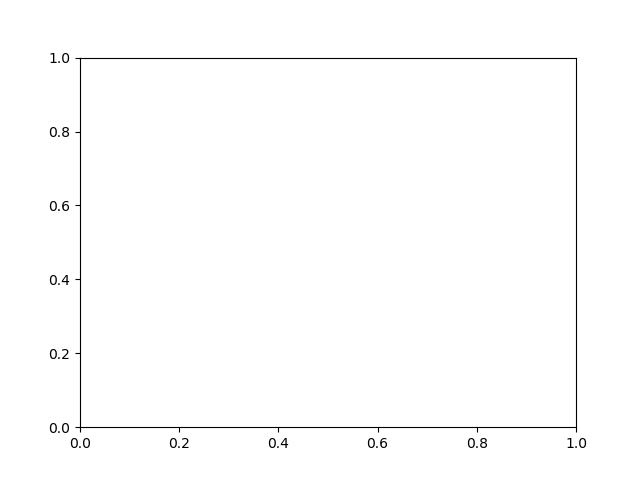

Step : 0, Signals : 0
Step : 1, Signals : 0
Step : 2, Signals : 0
Step : 3, Signals : 0
Step : 4, Signals : 0
Step : 5, Signals : 0
Step : 6, Signals : 0
Step : 7, Signals : 0
Step : 8, Signals : 0
Step : 9, Signals : 0
Step : 10, Signals : 0
Step : 11, Signals : 0
Step : 12, Signals : 0
Step : 13, Signals : 0
Step : 14, Signals : 0
Step : 15, Signals : 0
Step : 16, Signals : 0
Step : 17, Signals : 0
Step : 18, Signals : 0
Step : 19, Signals : 0
Step : 20, Signals : 0
Step : 21, Signals : 0
Step : 22, Signals : 0
Step : 23, Signals : 0
Step : 24, Signals : 0
Step : 25, Signals : 0
Step : 26, Signals : 0
Step : 27, Signals : 0
Step : 28, Signals : 0
Step : 29, Signals : 0
Step : 30, Signals : 0
Step : 31, Signals : 0
Step : 32, Signals : 0
Step : 33, Signals : 0
Step : 34, Signals : 0
Step : 35, Signals : 0
Step : 36, Signals : 0
Step : 37, Signals : 0
Step : 38, Signals : 0
Step : 39, Signals : 0
Step : 40, Signals : 0
Step : 41, Signals : 0
Step : 42, Signals : 0
Step : 43, Signals : 

Step : 194, Signals : 24
Step : 195, Signals : 24
Step : 196, Signals : 24
Step : 197, Signals : 24
Step : 198, Signals : 24
Step : 199, Signals : 24
Step : 200, Signals : 24
Step : 201, Signals : 24
Step : 202, Signals : 24
Step : 203, Signals : 24
Step : 204, Signals : 24
Step : 205, Signals : 24
Step : 206, Signals : 24
Step : 207, Signals : 24
Step : 208, Signals : 24
Step : 209, Signals : 24
Step : 210, Signals : 24
Step : 211, Signals : 24
Step : 212, Signals : 24
Step : 213, Signals : 24
Step : 214, Signals : 24
Step : 215, Signals : 24
Step : 216, Signals : 24
Step : 217, Signals : 24
Step : 218, Signals : 24
Step : 219, Signals : 24
Step : 220, Signals : 24
Step : 221, Signals : 24
Step : 222, Signals : 24
Step : 223, Signals : 24
Step : 224, Signals : 24
Step : 225, Signals : 24
Step : 226, Signals : 24
Step : 227, Signals : 24
Step : 228, Signals : 24
Step : 229, Signals : 24
Step : 230, Signals : 24
Step : 231, Signals : 24
Step : 232, Signals : 24
Step : 233, Signals : 24


Step : 430, Signals : 39
Step : 431, Signals : 39
Step : 432, Signals : 39
Step : 433, Signals : 39
Step : 434, Signals : 39
Step : 435, Signals : 39
Step : 436, Signals : 39
Step : 437, Signals : 39
#####In signal : tensor([1., 0., 0.]), 
Step : 438, Signals : 40
Weights : tensor([-0.0052, -0.0071]), mean : tensor([0.0019, 0.0030]), exp_error : tensor([0.2400, 0.3658])

Step : 439, Signals : 40
#####In signal : tensor([0., 1., 0.]), 
Step : 440, Signals : 41
Weights : tensor([ 0.9915, -0.0053]), mean : tensor([0.6369, 0.0019]), exp_error : tensor([0.0133, 0.2357])

Step : 441, Signals : 41
#####In signal : tensor([0., 0., 1.]), 
Step : 442, Signals : 42
Weights : tensor([0.9872, 0.9919]), mean : tensor([0.4150, 0.6342]), exp_error : tensor([0.0130, 0.0126])

Step : 443, Signals : 42
Step : 444, Signals : 42
Step : 445, Signals : 42
Step : 446, Signals : 42
Step : 447, Signals : 42
Step : 448, Signals : 42
Step : 449, Signals : 42
Step : 450, Signals : 42
Step : 451, Signals : 42
Step 

Step : 633, Signals : 60
Step : 634, Signals : 60
Step : 635, Signals : 60
Step : 636, Signals : 60
Step : 637, Signals : 60
Step : 638, Signals : 60
Step : 639, Signals : 60
Step : 640, Signals : 60
Step : 641, Signals : 60
Step : 642, Signals : 60
Step : 643, Signals : 60
Step : 644, Signals : 60
Step : 645, Signals : 60
Step : 646, Signals : 60
Step : 647, Signals : 60
#####In signal : tensor([1., 0., 0.]), 
Step : 648, Signals : 61
Weights : tensor([-0.0012, -0.0013]), mean : tensor([1.1536e-08, 1.7754e-08]), exp_error : tensor([0.0819, 0.1276])

Step : 649, Signals : 61
#####In signal : tensor([0., 1., 0.]), 
Step : 650, Signals : 62
Weights : tensor([ 9.9784e-01, -5.1805e-04]), mean : tensor([6.2944e-01, 1.1221e-08]), exp_error : tensor([0.0093, 0.0816])

Step : 651, Signals : 62
#####In signal : tensor([0., 0., 1.]), 
Step : 652, Signals : 63
Weights : tensor([0.9972, 0.9987]), mean : tensor([0.4028, 0.6365]), exp_error : tensor([0.0079, 0.0057])

Step : 653, Signals : 63
#####I

Step : 799, Signals : 87
Step : 800, Signals : 87
Step : 801, Signals : 87
Step : 802, Signals : 87
Step : 803, Signals : 87
Step : 804, Signals : 87
Step : 805, Signals : 87
Step : 806, Signals : 87
Step : 807, Signals : 87
Step : 808, Signals : 87
Step : 809, Signals : 87
Step : 810, Signals : 87
Step : 811, Signals : 87
Step : 812, Signals : 87
Step : 813, Signals : 87
Step : 814, Signals : 87
Step : 815, Signals : 87
Step : 816, Signals : 87
Step : 817, Signals : 87
Step : 818, Signals : 87
Step : 819, Signals : 87
Step : 820, Signals : 87
Step : 821, Signals : 87
Step : 822, Signals : 87
Step : 823, Signals : 87
Step : 824, Signals : 87
Step : 825, Signals : 87
Step : 826, Signals : 87
Step : 827, Signals : 87
Step : 828, Signals : 87
Step : 829, Signals : 87
Step : 830, Signals : 87
Step : 831, Signals : 87
Step : 832, Signals : 87
Step : 833, Signals : 87
Step : 834, Signals : 87
Step : 835, Signals : 87
Step : 836, Signals : 87
Step : 837, Signals : 87
Step : 838, Signals : 87


Step : 1015, Signals : 105
Step : 1016, Signals : 105
Step : 1017, Signals : 105
Step : 1018, Signals : 105
Step : 1019, Signals : 105
Step : 1020, Signals : 105
Step : 1021, Signals : 105
Step : 1022, Signals : 105
Step : 1023, Signals : 105
Step : 1024, Signals : 105
Step : 1025, Signals : 105
Step : 1026, Signals : 105
Step : 1027, Signals : 105
Step : 1028, Signals : 105
Step : 1029, Signals : 105
Step : 1030, Signals : 105
Step : 1031, Signals : 105
Step : 1032, Signals : 105
Step : 1033, Signals : 105
Step : 1034, Signals : 105
Step : 1035, Signals : 105
Step : 1036, Signals : 105
Step : 1037, Signals : 105
Step : 1038, Signals : 105
Step : 1039, Signals : 105
Step : 1040, Signals : 105
Step : 1041, Signals : 105
Step : 1042, Signals : 105
Step : 1043, Signals : 105
Step : 1044, Signals : 105
Step : 1045, Signals : 105
Step : 1046, Signals : 105
Step : 1047, Signals : 105
Step : 1048, Signals : 105
Step : 1049, Signals : 105
Step : 1050, Signals : 105
Step : 1051, Signals : 105
S

Step : 1201, Signals : 126
Step : 1202, Signals : 126
Step : 1203, Signals : 126
Step : 1204, Signals : 126
Step : 1205, Signals : 126
Step : 1206, Signals : 126
Step : 1207, Signals : 126
Step : 1208, Signals : 126
Step : 1209, Signals : 126
Step : 1210, Signals : 126
Step : 1211, Signals : 126
Step : 1212, Signals : 126
Step : 1213, Signals : 126
Step : 1214, Signals : 126
Step : 1215, Signals : 126
Step : 1216, Signals : 126
Step : 1217, Signals : 126
Step : 1218, Signals : 126
Step : 1219, Signals : 126
Step : 1220, Signals : 126
Step : 1221, Signals : 126
Step : 1222, Signals : 126
Step : 1223, Signals : 126
Step : 1224, Signals : 126
Step : 1225, Signals : 126
Step : 1226, Signals : 126
Step : 1227, Signals : 126
Step : 1228, Signals : 126
Step : 1229, Signals : 126
Step : 1230, Signals : 126
Step : 1231, Signals : 126
Step : 1232, Signals : 126
Step : 1233, Signals : 126
Step : 1234, Signals : 126
Step : 1235, Signals : 126
#####In signal : tensor([1., 0., 0.]), 
Step : 1236, Si

KeyboardInterrupt: 

In [138]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

epochs = 2000

x_fire = np.array(random.sample(range(1,epochs//6), (epochs//6) // 5))*6

#x_fire = np.array(list(range(0,epochs,6)))
y_fire = (x_fire + 2)
z_fire = (y_fire + 2)

#print(x_fire)
#x_fire = []
signals = 0
for e in range(epochs):
    in_stream = torch.tensor([e in x_fire, e in y_fire, e in z_fire], dtype=torch.float)
    
    
    if 1 in in_stream:
        print("#####In signal : {}, ".format(in_stream.data))
        signals += 1
    
    print("Step : {}, Signals : {}".format(e, signals))
    #print()    
    #print()
    fig.canvas.set_window_title("Step : {},   {}".format(e,in_stream.data))
    
    s = model(in_stream)
    #draw_spikes(s,[2,1], ax)
    #fig.canvas.draw()
    #time.sleep(0.1)

In [4]:
def get_uncertainty( c):
       
        v = (torch.log10(c)/torch.log10(torch.tensor(0.9).float())) 
        return v**1/2
    
print(get_uncertainty(torch.tensor(0.1).float()))

tensor(10.9272)


In [5]:
print(np.array(list(range(0,epochs,6))))

[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198]


In [6]:
print(x_fire)

[ 48 138 102 120  96 156]


In [115]:
s = torch.rand([5,1])
t = torch.rand([5,1])

In [116]:
print(s)
print(t)
print(torch.max(s,t))


tensor([[0.7181],
        [0.5037],
        [0.1335],
        [0.7296],
        [0.7519]])
tensor([[0.9017],
        [0.1215],
        [0.1997],
        [0.0990],
        [0.6017]])
tensor([[0.9017],
        [0.5037],
        [0.1997],
        [0.7296],
        [0.7519]])


In [97]:
print(0.6120/ 0.9246)

0.6619078520441272
